<a href="https://colab.research.google.com/github/patel-zeel/Nonstat-exps/blob/main/gp_extra/GP_Extra_LLS_self_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!git clone https://github.com/jmetzen/gp_extras.git
!cd gp_extras;python setup.py install;
!pip -qq install pods
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RBF, WhiteKernel
from gp_extras.kernels import LocalLengthScalesKernel
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Self defined class

In [3]:
## Terminology is consistent with paper 
# Paper name: Nonstationary Gaussian Process Regression Using Point Estimates of Local Smoothness

class LLS:
  def __init__(self, N=1): # N = Number of local points
    self.N = N
    self.name = 'LLS'

    # Keeping track of refiting the model to modify K_XX efficiently
    self.fit_count = 0
    self.refit_count = 0

  def rbf(self, x1, x2, sigma_l_bar): # RBF for GP_l without variance or noise
    return np.exp(-(x1-x2.T)**2/(2*(sigma_l_bar**2)))
  """
  # Deprecated
  def K_XX(self, x1, x2, sigma_f, sigma_n, l): # From Eq. 7 
    p = l.T@l
    P_r = p
    P_c = p.T
    P_s = P_r + P_c
    E = np.exp(-((x1-x2.T)**2) / P_s)

    return (sigma_f**2)*(0.5**-0.5)*(P_r**0.25)*(P_c**0.25)*(P_s**-0.5)*E  # Eq. 7
  """
  def K(self, x1, x2, sigma_f, sigma_n, lx1, lx2): # Main kernel function by Generalizing Eq. 7
    P_rc = (lx1@(lx2.T))**2
    P_s = 0.5 * ((lx1**2) + (lx2.T**2))
    E = np.exp(-((x1-x2.T)**2) / P_s)

    return (sigma_f**2)*(P_rc**0.25)*(P_s**-0.5)*E
  
  def K_(self, x1, x2): # Main kernel function (fitted)
    lx1 = self.predict_lengthscales(x1)
    lx2 = self.predict_lengthscales(x2)
    P_rc = (lx1@(lx2.T))**2
    P_s = 0.5 * ((lx1**2) + (lx2**2).T)
    E = np.exp(-((x1-x2.T)**2) / P_s)

    return (self.sigma_f**2)*(P_rc**0.25)*(P_s**-0.5)*E

  def objective(self, params): # From equation 6 in section 4.1
    sigma_f = params[0]
    sigma_n = params[1]
    l_bar = np.array(params[2:-1]).reshape(-1,1)
    sigma_l_bar = params[-1]

    # Calculations for GP_l
    K_X_barX_bar = self.rbf(self.X_bar, self.X_bar, sigma_l_bar) # shape of (X_bar, X_bar)
    K_XX_bar = self.rbf(self.X, self.X_bar, sigma_l_bar) # shape of (X, X_bar)

    # exponent of predictive mean of lengthscales for entire X
    self.l = np.exp(K_XX_bar@np.linalg.pinv(K_X_barX_bar)@np.log(l_bar)) # shape of (X, X_bar)@(X_bar, X_bar)@(X_bar, 1) = (X, 1)

    # Evaluating global kernel
    K_XX = self.K(self.X, self.X, sigma_f, sigma_n, self.l, self.l) + (sigma_n**2)*np.eye(self.X.shape[0])

    L_theta =  self.y.T@np.linalg.pinv(K_XX)@self.y +\
               np.log(np.linalg.det(K_XX)) +\
               np.log(np.linalg.det(K_X_barX_bar)) # Eq. 6

    return L_theta[0,0]

  def fit(self, X, y, sigma_f=1., sigma_n=1., sigma_l_bar=0.1, n_restarts_optimizer=10):
    assert len(X.shape) == 2, "X must be 2D"
    assert len(y.shape) == 2, "y must be 2D"
    assert y.shape[1] == 1, "y must be of shape (*,1)"

    self.X = X
    self.y = y
    if self.N <= self.X.shape[0]:
      kmeans = KMeans(n_clusters=self.N)
      self.X_bar = kmeans.fit(X).cluster_centers_
    else:
      self.X_bar = X
    sigma_f = float(sigma_f)
    sigma_n = float(sigma_n)
    sigma_l_bar = float(sigma_l_bar)

    # Fitting
    self.refit_count += 1
    optim_fun = np.inf
    for cycle in range(n_restarts_optimizer):
      # initialize lengthscales for support points
      l_bar = (0.1*np.ones((self.X_bar.shape[0], ))+np.abs(np.random.normal(0,1,self.X_bar.shape[0]))).tolist()
      # print('initial l_bar', l_bar)
      try:
        res = scipy.optimize.minimize(self.objective, [sigma_f]+[sigma_n]+l_bar+[sigma_l_bar], bounds=[(10**-5,10**5) for _ in range(3+len(l_bar))])
      except np.linalg.LinAlgError:
        #print('cycle',cycle,'did not converge')
        continue
      except ValueError:
        #print('cycle',cycle,'did not converge')
        continue
      # print(res.fun, 'optim value in cycle', cycle)
      if res.fun==-np.inf:
        continue
      if res.fun<optim_fun:
        optim_fun = res.fun
        self.sigma_f = res.x[0]
        self.sigma_n = res.x[1]
        self.l_bar = np.array(res.x[2:-1]).reshape(-1,1)
        self.sigma_l_bar = res.x[-1]
    
    self.params = {'likelihood':optim_fun, 'global variance':self.sigma_f, 'noise_level':self.sigma_n**2, 
                   'N_lengthscales':self.l_bar, 'GP_l_lengthscale':self.sigma_l_bar}
    return self
    
  def get_params(self):
    return self.params
  
  def predict_lengthscales(self, X_hat):
    K_X_barX_bar = self.rbf(self.X_bar, self.X_bar, self.sigma_l_bar)
    K_XX_bar = self.rbf(X_hat, self.X_bar, self.sigma_l_bar)

    l = np.exp(K_XX_bar@np.linalg.pinv(K_X_barX_bar)@np.log(self.l_bar))
    return l

  def predict(self, X_hat, return_cov=False):
    if self.refit_count < 1:
      raise AssertionError("Model is not fitted yet. Please fit using .fit(X, y) method first.")
    if self.refit_count>self.fit_count:
      self.fit_count=self.refit_count
      self.K_XX_inv = np.linalg.pinv(self.K_(self.X, self.X) + (self.sigma_n**2)*np.eye(self.X.shape[0]))
    K_X_hatX = self.K_(X_hat, self.X)
    mean = K_X_hatX@self.K_XX_inv@self.y
    if return_cov:
      cov = self.K_(X_hat, X_hat) - K_X_hatX@self.K_XX_inv@K_X_hatX.T
    return mean, cov

## Step function

shape of train_X= (20, 1) shape of train_y= (20, 1)


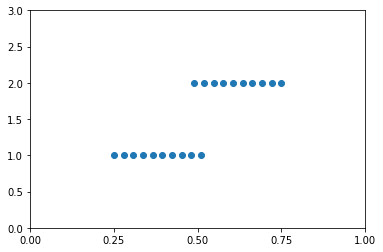

In [4]:
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

In [5]:
# Stationary kernel
def sklearn_gp(K):
  kernel = C() * K + WhiteKernel()
  return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=0)
gp = sklearn_gp(RBF())
gp.name = 'sklearn_gp'
print("Stationary kernel=\n", gp.kernel,sep='')

Stationary kernel=
1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


1.32**2 * RBF(length_scale=1.74) + WhiteKernel(noise_level=0.0711)
{'likelihood': -18.746600847907985, 'global variance': 1.3154501713169984, 'noise_level': 0.07107185980349143, 'N_lengthscales': array([[2.45473034]]), 'GP_l_lengthscale': 228.0920123807812}
{'likelihood': -29.86174143666191, 'global variance': 1.3071947648298412, 'noise_level': 0.06956840677443464, 'N_lengthscales': array([[558.64978936],
       [190.38547421]]), 'GP_l_lengthscale': 264.299961062269}
{'likelihood': -20.69099667787447, 'global variance': 1.1250765625726005, 'noise_level': 0.03717019835826695, 'N_lengthscales': array([[1.01559146],
       [2.98249202],
       [9.43527722]]), 'GP_l_lengthscale': 0.0042808733975721125}
{'likelihood': -51.192654071495596, 'global variance': 7.777168299793131, 'noise_level': 0.09848694376669821, 'N_lengthscales': array([[99.69489257],
       [51.79213767],
       [79.00039048],
       [67.15375373]]), 'GP_l_lengthscale': 32.82831272320777}
{'likelihood': -58.491872248849006,

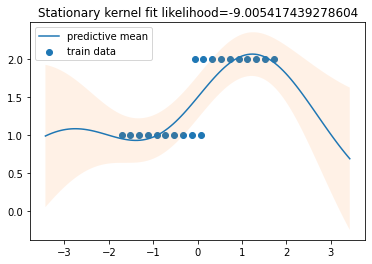

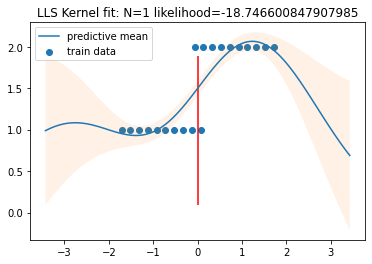

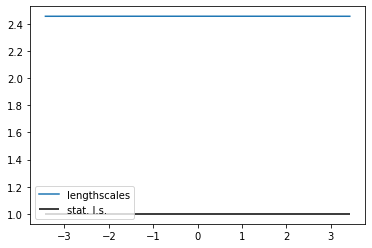

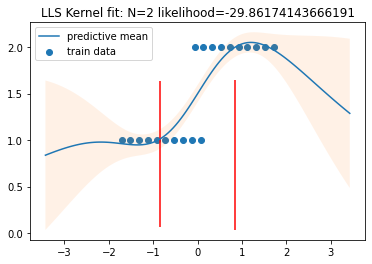

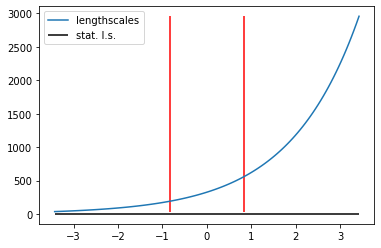

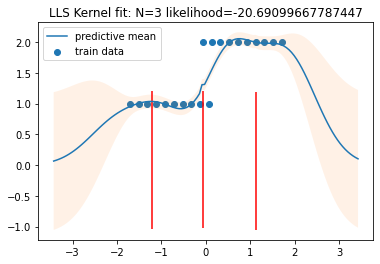

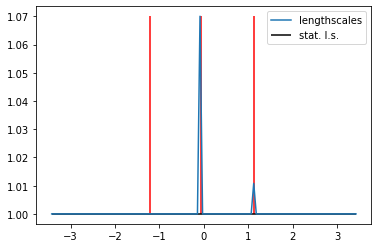

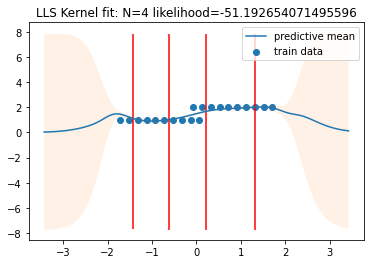

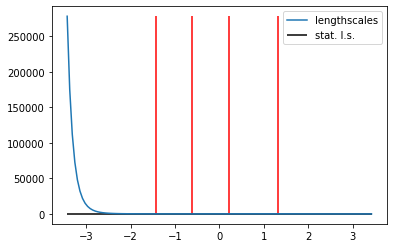

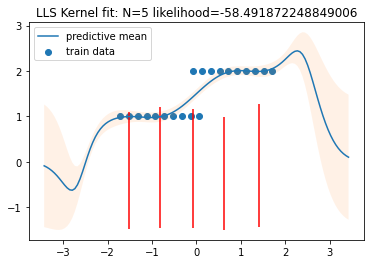

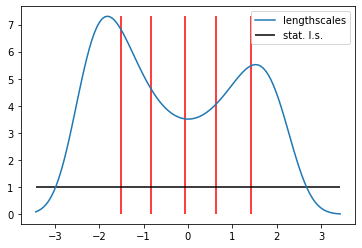

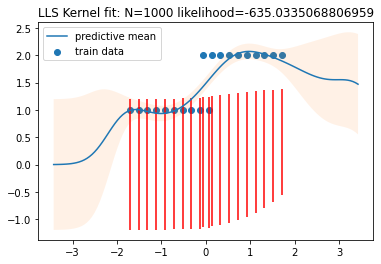

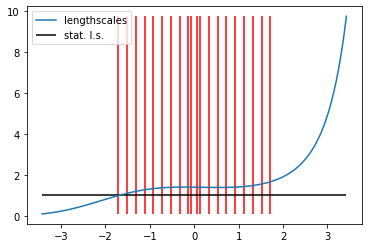

In [6]:
stat_lengthscale = None
def fit_predict_plot(model, title):
  global stat_lengthscale
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  model.fit(train_XX, train_y)
  pred_y, pred_cov = model.predict(test_XX, return_cov=True)
  pred_std = (pred_cov.diagonal()**0.5).squeeze()
  plt.scatter(train_XX, train_y, label='train data')
  plt.plot(test_XX, pred_y, label='predictive mean')
  plt.fill_between(test_XX.squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
  if model.name == 'LLS':
    plt.title(title+' likelihood='+str(model.params['likelihood']))
    plt.vlines(model.X_bar, pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, color='r')
    plt.legend()
    plt.figure()
    pred_l = model.predict_lengthscales(test_XX)
    plt.plot(test_XX, pred_l, label='lengthscales')
    plt.vlines(model.X_bar, pred_l.min(), pred_l.max(), color='r')
    plt.hlines(stat_lengthscale, test_XX.min(), test_XX.max(), label='stat. l.s.')
    print(model.get_params())
    plt.legend()
  else:
    stat_lengthscale = model.get_params()['kernel__k1__k2__length_scale']
    plt.title(title+' likelihood='+str(model.log_marginal_likelihood_value_))
    print(model.kernel_)
  plt.legend()

fit_predict_plot(gp, 'Stationary kernel fit')
N =1
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =2
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =3
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =4
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =1000
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))

## Olympic marathon data

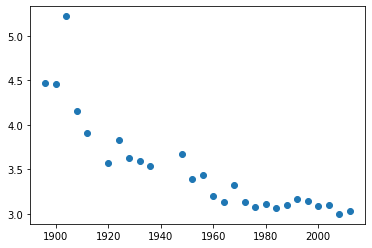

In [7]:
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()
train_X = data['X']
test_X = np.linspace(data['X'].min()-10, data['X'].max()+10, 120).reshape(-1,1)
train_y = data['Y']
plt.scatter(train_X, train_y);

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = lambda n: (C()*LocalLengthScalesKernel.construct(train_XX, l_samples=n)) + WhiteKernel()
def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
nonstat_gp = lambda n: GaussianProcessRegressor(kernel=nonstat_kernel(n), alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

## Testing

5.04**2 * RBF(length_scale=4.28) + WhiteKernel(noise_level=0.0485)
{'likelihood': -35.72088810710745, 'global variance': 5.030946457758629, 'noise_level': 0.048545258912688, 'N_lengthscales': array([[6.02276311]]), 'GP_l_lengthscale': 58.78474110012165}
{'likelihood': -46.360723292499785, 'global variance': 4.306046244970005, 'noise_level': 0.048033522655758054, 'N_lengthscales': array([[93.88624189],
       [57.43766441]]), 'GP_l_lengthscale': 230.6505371908133}
{'likelihood': -69.43530444685683, 'global variance': 2.5058685879789597, 'noise_level': 0.006211524618525765, 'N_lengthscales': array([[5.28846898],
       [0.57399982],
       [8.69914739]]), 'GP_l_lengthscale': 68.37609050990915}
{'likelihood': -79.55673454531487, 'global variance': 3.681716535847722, 'noise_level': 0.007360774614500699, 'N_lengthscales': array([[ 34.53041898],
       [168.28136158],
       [ 13.91761876],
       [ 15.76656197]]), 'GP_l_lengthscale': 12.639365210008526}
{'likelihood': -87.6562789851405, 'gl

AttributeError: ignored

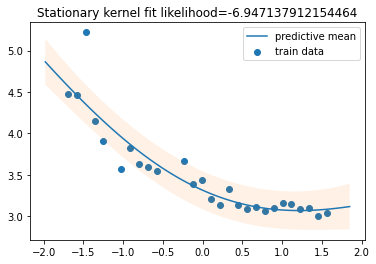

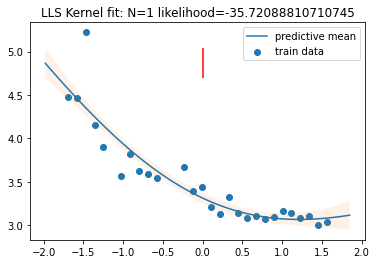

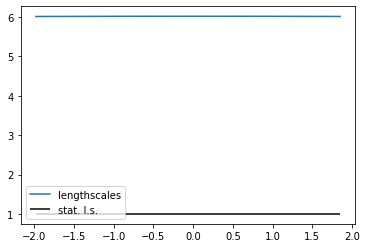

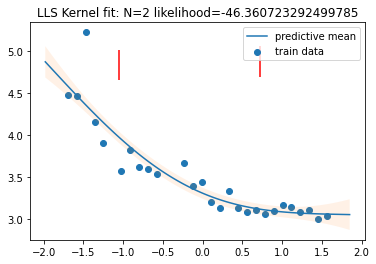

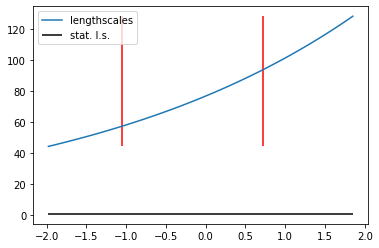

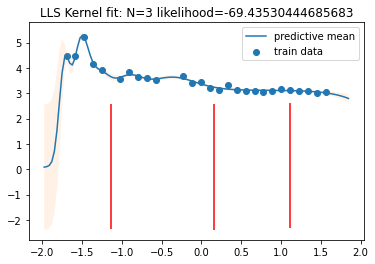

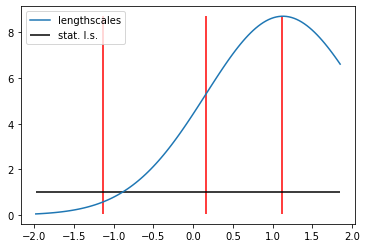

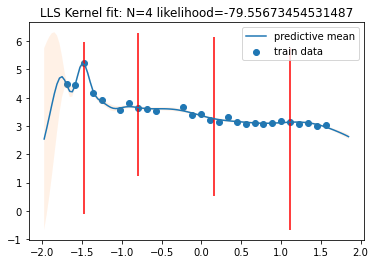

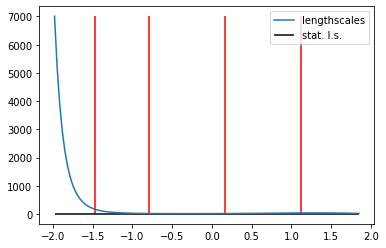

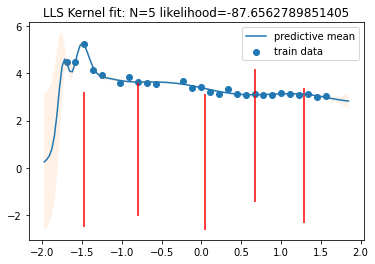

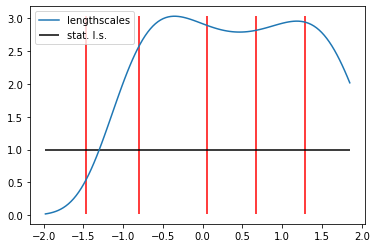

<Figure size 432x288 with 0 Axes>

In [8]:
fit_predict_plot(gp, 'Stationary kernel fit')
N =1
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =2
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =3
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =4
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =1000
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))

## 4 functions joint

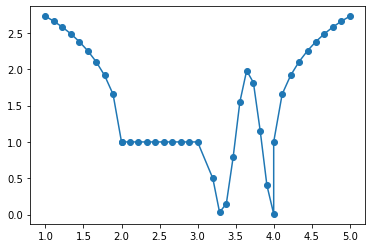

In [9]:
train_X1 = np.linspace(1,2,10);train_X2 = np.linspace(2,3,10);train_X3 = np.linspace(3.2,4,10);train_X4 = np.linspace(4,5,10);
train_y1 = np.sqrt(4-train_X1**2)+1;train_y2 = np.ones(10);train_y3 = np.sin(train_X3*9)+1;train_y4 = np.sqrt(((2)**2)-(train_X1-3)**2)+1;
train_X = np.concatenate([train_X1, train_X2, train_X3, train_X4]).reshape(-1,1)
test_X = np.linspace(0,6,60).reshape(-1,1)
train_y = np.concatenate([train_y1, train_y2, train_y3, train_y4]).reshape(-1,1)
plt.plot(train_X, train_y,'o-');

3.07**2 * RBF(length_scale=1.89) + WhiteKernel(noise_level=0.193)
{'likelihood': -9.08255541708563, 'global variance': 2.1422037880429543, 'noise_level': 0.18221007282358584, 'N_lengthscales': array([[2.23889461]]), 'GP_l_lengthscale': 1.188001100898107}
{'likelihood': -17.240113721156945, 'global variance': 1.3839030894706932, 'noise_level': 0.11676317635879654, 'N_lengthscales': array([[0.27797014],
       [0.74585298]]), 'GP_l_lengthscale': 0.07791985958585347}
{'likelihood': -38.57934253941606, 'global variance': 2.115217267334666, 'noise_level': 0.03360275225925823, 'N_lengthscales': array([[0.22736592],
       [1.40440372],
       [1.87580415]]), 'GP_l_lengthscale': 0.5218597773377118}
{'likelihood': -51.49040594399466, 'global variance': 1.8112479995570476, 'noise_level': 0.02622777205176629, 'N_lengthscales': array([[0.22927259],
       [1.87219069],
       [1.16991904],
       [1.33554961]]), 'GP_l_lengthscale': 0.2646692226575162}
{'likelihood': -83.21951968015276, 'global va

AttributeError: ignored

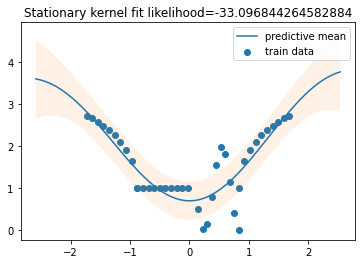

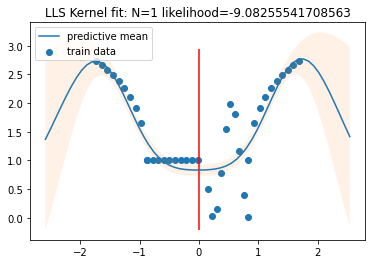

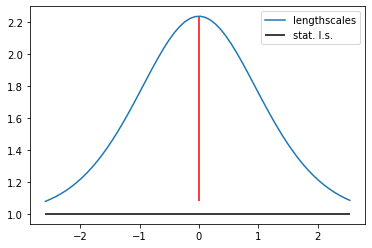

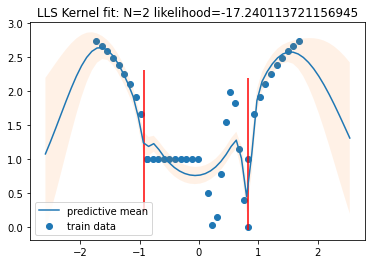

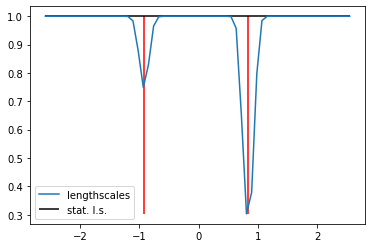

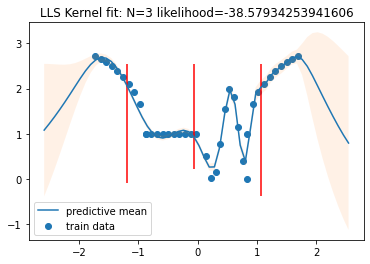

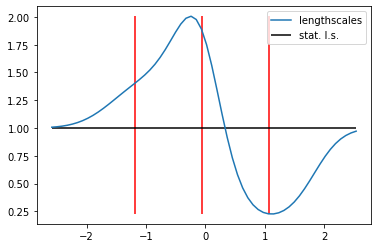

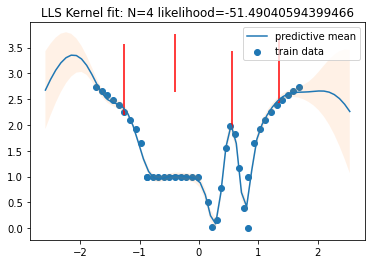

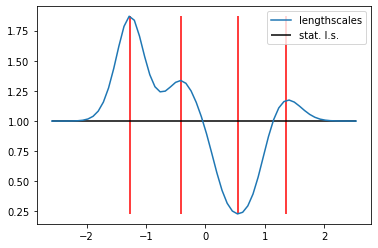

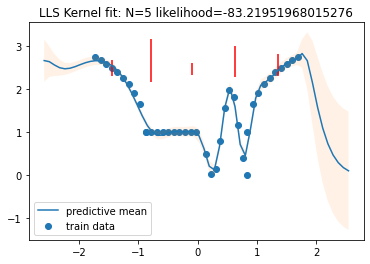

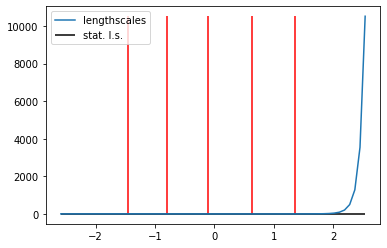

<Figure size 432x288 with 0 Axes>

In [10]:
fit_predict_plot(gp, 'Stationary kernel fit')
N =1
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =2
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =3
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =4
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =1000
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))